# Bloqade python demonstration

It is simple to install bloqade using pip https://pypi.org/project/bloqade/ via `pip install bloqade`. Documentation for bloqade is provided here https://queracomputing.github.io/bloqade-python/latest/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bloqade import start

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

One can construct programs using a builder pattern. This pattern means that you can chain together commands to create a complete program.

Let us demonstrate this functionality by implementing the "hello world" of analog Hamiltonian simulation: Rabi oscillations. Aquila's neutral atom hardware requires 4 time dependent fields: position of atoms; Rabi frequency as a function of time; Rabi frequency phase as a function of time; Detuning as a function of time.

In [2]:
#Start by specifying an atom position in 2d space. Units are in micrometers
initial_geometry = start.add_position((0,0))

#Next, define the Rabi frequency as a piecewise linear function
rabi_wf = initial_geometry.rydberg.rabi.amplitude.uniform.piecewise_linear(
    durations=[0.06, 0.06, 0.06], values=[0, 13.09, 13.09,0])

#Next, define the detuning, which we choose to be constant of 0
program = rabi_wf.detuning.uniform.constant( duration=0.18, value = 0.0 )

# Phase, if unspecified, is implied to be a constant through evolution.
#program_with_phase = program.rydberg.rabi.phase.uniform.constant( duration=[0.22], value=0.0 )

In [3]:
# This specification can be chained together in a single sequence 

program = (
    start
    .add_position((0,0))
    .rydberg.rabi.amplitude.uniform
    .piecewise_linear(durations=[0.06, 0.06, 0.06], values=[0, 13.09, 13.09, 0])
    .detuning.uniform
    .constant(duration = 0.18, value = 0.0)
    .rydberg.rabi.phase.uniform
    .constant(duration=0.18, value=0.0)
)

In [4]:
# We can immediately inspect the contents of a program with `.show()`

program.show()

Given a specific program instance, one may run it through emulation or submit through Aquila. Lets do both!

## Emulate
First, let us emulate this evolution using Braket's local emulator

In [5]:
braket_emulated = program.braket.local_emulator()
results = braket_emulated.run(1000).report()

The protocol was designed to implement a $\pi/2$ protocol preparing the Y superposition state $(|0\rangle + i|1\rangle)/\sqrt{2}$. It should give us a 50% chance of measuring ground or excited state. Is this true?

In [6]:
results.counts

[OrderedDict([('0', 523), ('1', 477)])]

## Submit to Aquila
Submission to Aquila is also simple. First, find your AWS credentials through your dashboard

In [7]:
%set_env AWS_DEFAULT_REGION=us-east-1
%set_env AWS_ACCESS_KEY_ID=X
%set_env AWS_SECRET_ACCESS_KEY=XX
%set_env AWS_SESSION_TOKEN=XXX

env: AWS_DEFAULT_REGION=us-east-1
env: AWS_ACCESS_KEY_ID=X
env: AWS_SECRET_ACCESS_KEY=XX
env: AWS_SESSION_TOKEN=XXX


Next, submit the job through Aquila. One of the very handy functionalities is to serialize results and runs to and from file. For this demo, let us load a previously run set of data from file.

In [8]:
from bloqade import save,load

ITS_DEMO_TIME = False
filename = "single_run_demo.json"

if ITS_DEMO_TIME==True:
    aquila     = program.braket.aquila()
    aquila_run = aquila.run(100)
    save(aquila_run,filename)
else:
    aquila_run = load(filename)
    
results_aquila    = aquila_run.report()
bitstrings_aquila = results_aquila.bitstrings()

Are these results consistent with being in the Y superposition state? Lets see!

In [9]:
print(results_aquila.counts)
results_aquila.show()

[OrderedDict([('0', 50), ('1', 50)])]


# And so much more...

Beyond this very basic functionality, bloqade adds extra flexibility at the convenience of the user. Let us implement **blockaded Rabi oscillations** on two atoms in this expanded example, which is a simple demonstration of how easy it is to generate entanglement.

## Feature: Unassigned programs
Instead of generating programs with explicit values, one can instead include variables which can be set later

In [10]:
from bloqade import var

program = (
    start
    .add_position([(0,0), (0,4)])
    .rydberg.rabi.amplitude.uniform
    .piecewise_linear(
        durations = [0.06, "time", 0.06], values = [0, 15, 15, 0]
    )
    .detuning.uniform
    .constant(duration = 0.12 + var("time"), value = 0.0)
    .phase.uniform.constant(
        duration = 0.12 + var("time"), value = 0.0
    )
)

In [11]:
program.assign(time=2.0).show()

## Feature: Batches of programs
Once the program with a variable `time` has been created, one can create a "batch" of tasks for a range of times

In [12]:
times = np.linspace(0.05,1,31)

program_assigned = program.batch_assign(time = times)

## Feature: QuEra emulator
Another back-end for simulation is a QuEra emulator, which is faster.

In [13]:
bloqade_emulated = program_assigned.bloqade.python()
results_bloqade = bloqade_emulated.run(2000).report()

bitstrings_bloqade = results_bloqade.bitstrings()

In [14]:
results_bloqade.show()

## Feature: Parallelization

Before we submit this program to Aquila, consider: it is silly to only implement dynamics of only two atoms when you can use up to 256 in a large area. Because interactions are extremely local, one can instead **parallelize** a small set of atoms many times a safe distance (~$25\mu$m) apart to reduce the number of measurements required to accumulate statistics.

In [15]:
program_parallelized = program_assigned.parallelize(cluster_spacing=25)

Neat! Now, let us submit to Aquila in the same manner. Because the number of shots will be a bit larger ($100*31$) we submit jobs asynchronously.

In [16]:
ITS_DEMO_TIME = False
filename = "blockaded_batch_demo.json"

if ITS_DEMO_TIME==True:
    aquila     = program_parallelized.braket.aquila()
    aquila_run = aquila.submit(100)
    
    save(filename,aquila_run)
else:
    aquila_run = load(filename)

Later on once the job has run through BraKet, we can retieve data using `*.fetch()`

In [17]:

if ITS_DEMO_TIME==True:
    aquila_run.fetch()                      # Fetch from remote
    save(filename,aquila_run) # Save results so you don't need to fetch every time
else:
    print("Its demo time")

Its demo time


In [18]:
# Plot here
aquila_run.report().show()

In [19]:
# Collect bitstring results for analysis
bitstrings_aquila = aquila_run.report().bitstrings() # why?
counts_aquila = aquila_run.report().counts
counts_emulate = results_bloqade.counts

In [20]:
def rydberg_state_probabilities(counts):
    probabilities_dict = {"0": [], "1": [], "2": []}

    # iterate over each of the task results
    for task_result in counts:
        # get total number of shots
        total_shots = sum(task_result.values())
        # get probability of each state
        probabilities_dict["0"].append(task_result.get("11", 0) / total_shots)
        probabilities_dict["1"].append(
            (task_result.get("10", 0) + task_result.get("01", 0)) / total_shots
        )
        probabilities_dict["2"].append(task_result.get("00", 0) / total_shots)

    return probabilities_dict


In [21]:
aquila_rydberg_state_probabilities = rydberg_state_probabilities(counts_aquila)
emulator_rydberg_state_probabilities =  rydberg_state_probabilities(counts_emulate)

(0.05, 1.0, -0.049850000000000005, 1.04685)

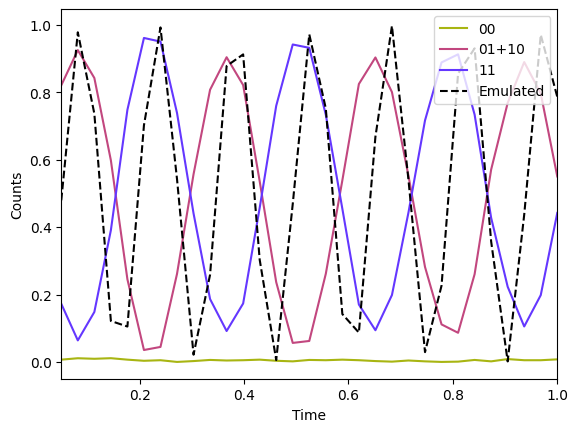

In [22]:
plt.plot(times,aquila_rydberg_state_probabilities["2"],label="00",color="#a8b512")
plt.plot(times,aquila_rydberg_state_probabilities["1"],label="01+10",color="#C2477F")
plt.plot(times,aquila_rydberg_state_probabilities["0"],label="11",color="#6437FF")

plt.plot(times,emulator_rydberg_state_probabilities["0"],"k--",label="Emulated")

plt.legend(loc=1)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.axis([min(times),max(times),plt.axis()[2],plt.axis()[3]])